In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import matplotlib.dates as mdates 
import numpy as np
import pandas as pd
import nltk
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from keras.models import Sequential
from keras.layers import LSTM, Dense
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime, timedelta
%matplotlib inline

# </h1><font size="6">
**Section 1. Sentiment Analysis on Reviews**  
**(See Detailed Method in Section 3)**


Note: In this part, since I already have the sentiment compound score of the title. So I grabbed a sample dataset containing 100 titles and analyzed their sentiments using textblob. Then I manually compare the two sentiment scores to see which one better fits the true sentiment.  
Plus, detailed sentiment analysis including volume estimate, topic modeling, and VADER process are in section 3.

In [2]:
#Read the file
rGME = pd.read_csv('rGME_dataset_features.csv')

C:\Users\10788\AppData\Local\Temp\ipykernel_4252\3528037558.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  rGME = pd.read_csv('rGME_dataset_features.csv')


In [3]:
rGME.head()

,Unnamed: 0,id,title,url,score,author,num_comments,date,flair,compound,...,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
0,0,kqfajb,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,https://www.reddit.com/r/GME/comments/kqfajb/y...,1.0,TitsDownOnly,9.0,2021-01-04,NaN,0.9872,...,0,0,6,0,0,0,0,0,0,0
1,1,kqjh2t,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,/r/wallstreetbets/comments/kqcwdo/gamestops_gr...,1.0,zoomermoney,1.0,2021-01-04,NaN,0.9906,...,0,0,3,0,0,0,0,0,0,0
2,2,kqvp7l,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1.0,TitsDownOnly,6.0,2021-01-05,NaN,0.5319,...,0,0,0,0,0,0,0,0,0,0
3,3,krcwch,You already know what we must do brothers and ...,/r/wallstreetbets/comments/kr98ym/gme_gang_we_...,1.0,dontforgettolive,4.0,2021-01-05,NaN,-0.2960,...,1,0,0,0,0,0,0,0,0,0
4,4,krnthg,ICR conference (11th Jan),https://www.reddit.com/r/GME/comments/krnthg/i...,1.0,nicky94,10.0,2021-01-06,NaN,0.0000,...,0,0,0,1,0,0,0,0,0,0


In [4]:
# Get columns we need
rgme = rGME[['date','title','compound']]
#change time format
rgme['date'] = pd.to_datetime(rgme['date'])

C:\Users\10788\AppData\Local\Temp\ipykernel_4252\1482396557.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rgme['date'] = pd.to_datetime(rgme['date'])


In [5]:
# Get rows in the range of January_May and June_August
rgme1_5 = rgme[(rgme['date'].dt.month >= 1) & (rgme['date'].dt.month <= 5)]
rgme6_8 = rgme[(rgme['date'].dt.month >= 6) & (rgme['date'].dt.month <= 8)]
#get sample data to make comparision
rgme1_5_sample = rgme1_5.iloc[:102]

In [6]:
from textblob import TextBlob

In [7]:
# Creat a def funtion to do sentiment analysis 
def analyze_sentiment(title):
    analysis = TextBlob(title)
    return analysis.sentiment.polarity 

In [8]:
# Apply the sentiment function on the sample set
rgme1_5_sample['sentiment'] = rgme1_5_sample['title'].apply(analyze_sentiment)

C:\Users\10788\AppData\Local\Temp\ipykernel_4252\2049517600.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rgme1_5_sample['sentiment'] = rgme1_5_sample['title'].apply(analyze_sentiment)


In [9]:
# pd.set_option('display.max_rows', None)

In [10]:
rgme1_5_sample

,date,title,compound,sentiment
0,2021-01-04,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,0.9872,0.000000
1,2021-01-04,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,0.9906,0.000000
2,2021-01-05,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,0.5319,-0.125000
3,2021-01-05,You already know what we must do brothers and ...,-0.2960,-0.300000
4,2021-01-06,ICR conference (11th Jan),0.0000,0.000000
...,...,...,...,...
97,2021-01-21,WHERE ARE THE FUCKING REINFORCEMENTS,0.0000,-0.600000
98,2021-01-21,Picked up more!,0.0000,0.625000
99,2021-01-21,Major News - Weekly Thread,0.0000,0.062500
100,2021-01-21,Can’t wait to repost this years down the line....,-0.2023,0.072222


After carefully comparing two scores, I find that the 'compound' column better score the sentiment so I decided to use compound score as sentiment score finally.

# </h1><font size="6">
**Section 2.
Time-Series Data Analysis**

## </h2><font size="4">
**2.1 Load Historical Time-Series Data and EDA**

In [11]:
#Load the Gamestop's historical stock data
ticker = 'GME'
# Ranging from 2020-1-1 to 2021-04-1
gme_data = yf.download(ticker, start='2021-01-01', end='2021-09-01')
# detect the data
gme_data.head()

C:\Users\10788\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,4.7500,4.7750,4.2875,4.3125,4.3125,40090000
2021-01-05,4.3375,4.5200,4.3075,4.3425,4.3425,19846000
2021-01-06,4.3350,4.7450,4.3325,4.5900,4.5900,24224800
2021-01-07,4.6175,4.8625,4.5050,4.5200,4.5200,24517200
2021-01-08,4.5450,4.5750,4.2700,4.4225,4.4225,25928000


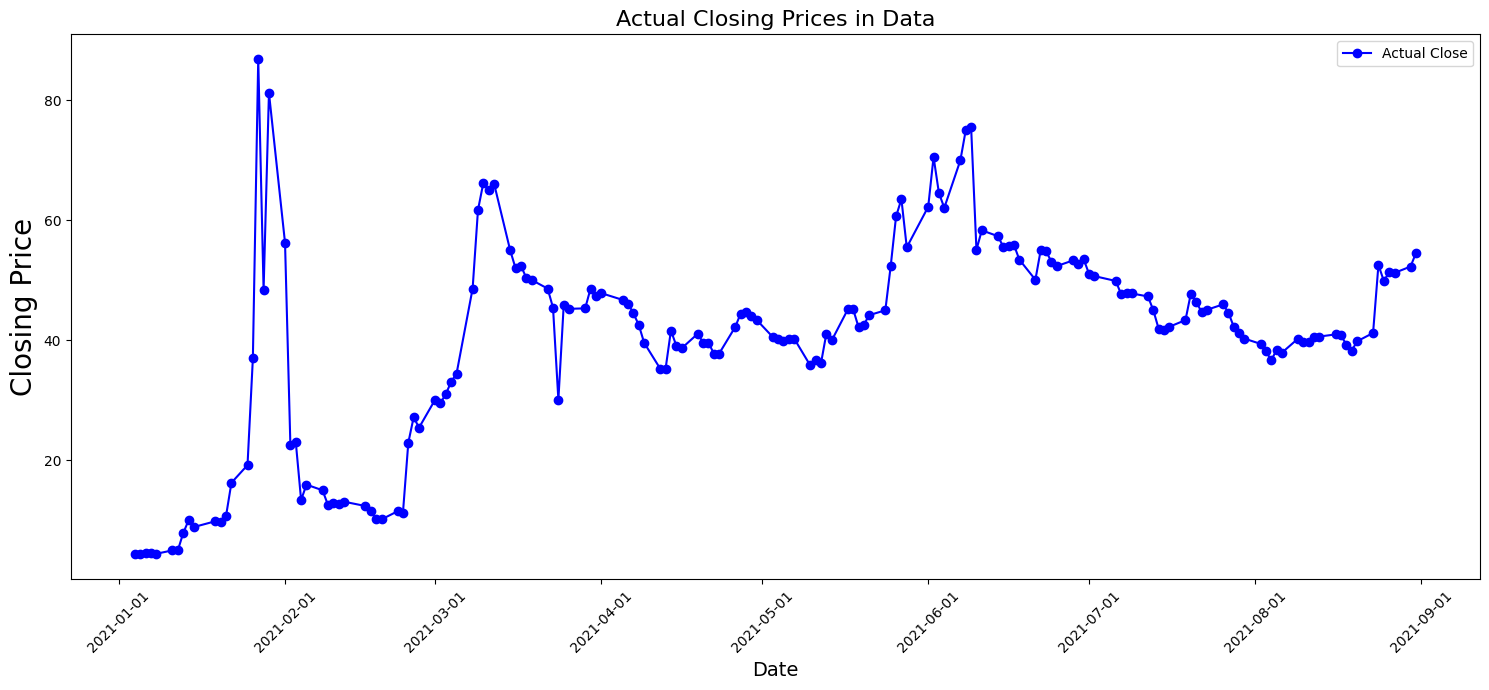

In [12]:
# Plot the time-series data
# Setting the plot size for better readability
plt.figure(figsize=(15, 7))

# Plotting the actual closing prices in the training period
plt.plot(gme_data.index, gme_data['Close'], label='Actual Close', color='blue', marker='o')

# Adding title and labels with font size adjustments
plt.title('Actual Closing Prices in Data', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=20)

#Set the date format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 

#Set the x-axis interval to be one month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish the actual values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

## </h2><font size="4">
**2.2 Feature engineering--Combine Sentiment Score and Stock Price Together**

In [13]:
#get data we need and group the scores at the same day
rgme_daily = rgme[['date','compound']].groupby('date').mean()
rgme_daily.head()

,compound
date,
2021-01-04,0.988900
2021-01-05,0.117950
2021-01-06,0.388850
2021-01-10,0.966700
2021-01-11,0.237925


In [14]:
# Grab the close column as object
data = gme_data['Close']
data.head()

Date
2021-01-04    4.3125
2021-01-05    4.3425
2021-01-06    4.5900
2021-01-07    4.5200
2021-01-08    4.4225
Name: Close, dtype: float64

In [15]:
#merge score and stock price
data = data.to_frame(name='stock')
merged_df = pd.merge(rgme_daily, data, left_on='date', right_on='Date', how='inner',right_index = True)
merged_df

,compound,stock
date,,
2021-01-04,0.988900,4.312500
2021-01-05,0.117950,4.342500
2021-01-06,0.388850,4.590000
2021-01-11,0.237925,4.985000
2021-01-12,-0.136600,4.987500
...,...,...
2021-08-25,0.133748,49.912498
2021-08-26,0.121672,51.305000
2021-08-27,0.136975,51.237499


## </h2><font size="4">
**2.3 Build up Time-Series Model Using LSTM**

In [16]:
# Split the test, train and predict data
train = data.iloc[:102] # January~May
test = data.iloc[102:] # June~August
len(test),len(train)

(65, 102)

In [17]:
# Reshape data
train_arr = train.values.reshape(-1, 1)
test_arr = test.values.reshape(-1, 1)

In [18]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_arr)
train_scaled = scaler.transform(train_arr)
test_scaled = scaler.transform(test_arr)

In [19]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
# Set the input and feature of the model and create time-series generator for analysis
input_n = 15
features_n = 1
generator_train = TimeseriesGenerator(train_scaled,train_scaled,length= input_n, batch_size = 1)

In [21]:
# build model by setting variables
model = Sequential()
model.add(LSTM(150, activation = 'relu', input_shape = (input_n,features_n)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [22]:
#check the model information
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 91351 (356.84 KB)
Trainable params: 91351 (356.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
#train the model
model.fit_generator (generator_train,epochs =200)

Epoch 1/200


C:\Users\10788\AppData\Local\Temp\ipykernel_4252\2646535761.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator (generator_train,epochs =200)



87/87 [==============================] - 2s 5ms/step - loss: 0.0465
Epoch 2/200
87/87 [==============================] - 1s 6ms/step - loss: 0.0277
Epoch 3/200
87/87 [==============================] - 0s 5ms/step - loss: 0.0274
Epoch 4/200
87/87 [==============================] - 1s 6ms/step - loss: 0.0233
Epoch 5/200
87/87 [==============================] - 0s 5ms/step - loss: 0.0211
Epoch 6/200
87/87 [==============================] - 0s 5ms/step - loss: 0.0193
Epoch 7/200
87/87 [==============================] - 0s 5ms/step - loss: 0.0206
Epoch 8/200
87/87 [==============================] - 1s 6ms/step - loss: 0.0178
Epoch 9/200
87/87 [==============================] - 0s 5ms/step - loss: 0.0154
Epoch 10/200
87/87 [==============================] - 1s 6ms/step - loss: 0.0160
Epoch 11/200
87/87 [==============================] - 0s 5ms/step - loss: 0.0150
Epoch 12/200
87/87 [==============================] - 0s 5ms/step - loss: 0.0135
Epoch 13/200
87/87 [============================

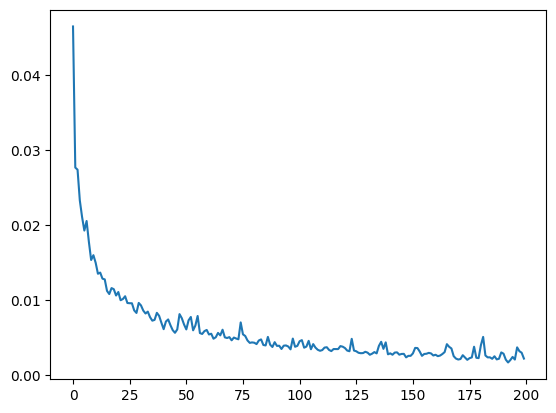

In [24]:
#visualize the loss function gradient decsent
plt.plot(range(len(model.history.history['loss'])),model.history.history['loss'])

## </h2><font size="4">
**2.4 Predict Using LSTM Model**

In [25]:
# Reference: Udemy course: Python for Time Series Data Analysis,https://www.udemy.com/course/python-for-time-series-data-analysis/learn/lecture/14522130#overview
# Create a list to store predicted data
test_predictions = []
# Get the last input_n points from the training data
first_eval_batch = train_scaled[-input_n:]
# reshape the data format
current_batch = first_eval_batch.reshape(1,input_n,features_n)
#predict in a loop
for i in range (len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 32ms/step


In [26]:
# rescale the data and flatten the data
test_nonscaled_predictions = scaler.inverse_transform(test_predictions)
test_nonscaled_predictions = test_nonscaled_predictions.flatten()

## </h2><font size="4">
**2.5 Evaluate the Model and Visualize the Predictions**

In [27]:
#Create the df to store predicted data and real world data
test_df = test

In [28]:
#add new columns to df
test_df['Predictions'] = test_nonscaled_predictions

C:\Users\10788\AppData\Local\Temp\ipykernel_4252\1568353863.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predictions'] = test_nonscaled_predictions


In [29]:
test_df.head()

,stock,Predictions
Date,,
2021-06-01,62.255001,48.594390
2021-06-02,70.559998,41.323241
2021-06-03,64.544998,39.018833
2021-06-04,62.090000,39.075792
2021-06-07,70.002502,40.850156


In [30]:
#Evaluate the model using MAE, MSE, MRE
from sklearn import metrics
MAE = metrics.mean_absolute_error(test_df['stock'],test_df['Predictions'])
MSE = metrics.mean_squared_error(test_df['stock'],test_df['Predictions'])
MRE = np.sqrt(MSE)
MAE,MSE,MRE

(9.33544460702209, 158.12785913873134, 12.574890024915977)

In [31]:
test_df.describe()

,stock,Predictions
count,65.000000,65.000000
mean,49.161961,40.931311
std,9.170583,2.852232
min,36.700001,35.635252
25%,41.215000,38.844463
50%,47.807499,40.364930
75%,53.535000,43.352251
max,75.639999,48.594390


<Figure size 1500x700 with 0 Axes>

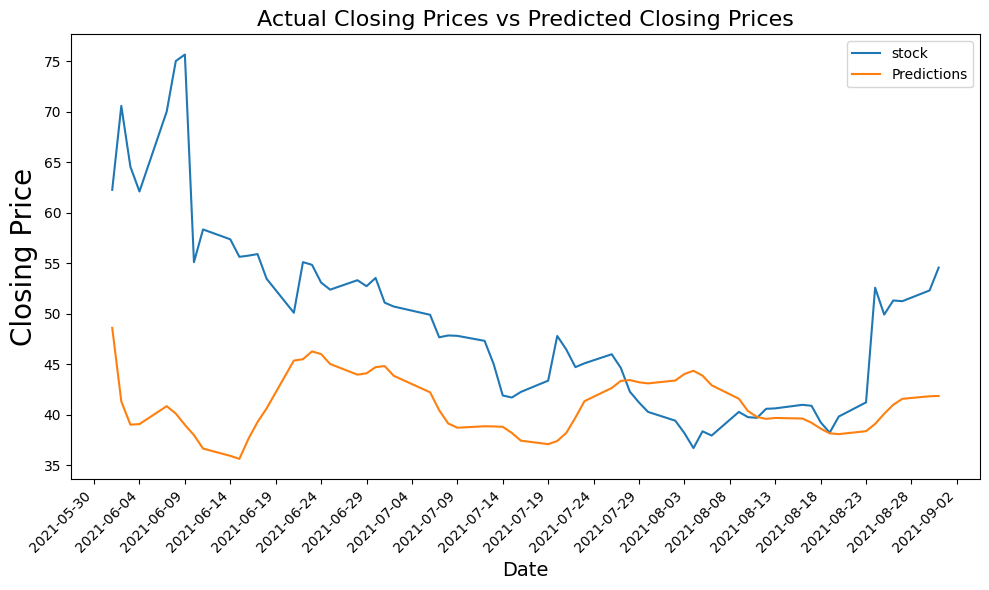

In [32]:
# Plot the time-series data
# Setting the plot size for better readability
plt.figure(figsize=(15, 7))

# Plotting 
test_df.plot(figsize=(10,6))

# Adding title and labels with font size adjustments
plt.title('Actual Closing Prices vs Predicted Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=20)

#Set the date format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 

#Set the x-axis interval to be one month
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5)) 

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish the actual values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

## </h2><font size="4">
**2.6 Conclusion**

1. Real world stock price higher than the predictions: June, July, second-half of August
Real-world stock price lower than the predictions: second-half late July, first-half of August
2. The data in June has a significant difference between real data and predictions. That might be because the past 15-day data is stable and there might be some promotions or marketing activities that attract more stakeholders. This is not due to the trends so there must be some other factors influencing the stock. So it is crucial to add in the sentiment score to drag the predictions up.
3. The data during 7-15~8-20 seems more accurate than other durations. It might due to the stableness of past day stock price and there are no more other external factors influencing more about the predictions.
4. See MRE, it is around 11.89, and for this case, the real-world data's sd is 9.17, and the prediction is 1.18, greater than both sd, so it means that my model does not predict the actual data well. Since the stock market is very changeable and there are many factors influencing it it is hard to predict the data very accurately. Plus, the standard deviations of predictions and actual price are also very different, meaning the model does not consider any other influential factors as well.


# </h1><font size="6">
**Section 3. Model Confusion**

Note：I just add compound variable as a feature in my previous LSTM model to make the model more fittable.

## </h2><font size="4">
**3.1 Train the Model**

In [33]:
#Train test split
train_merged = merged_df.iloc[:90]
test_merged =merged_df.iloc[90:]

In [34]:
test_merged

,compound,stock
date,,
2021-06-01,0.176447,62.255001
2021-06-02,0.135441,70.559998
2021-06-03,0.167384,64.544998
2021-06-04,0.193930,62.090000
2021-06-07,0.128329,70.002502
...,...,...
2021-08-25,0.133748,49.912498
2021-08-26,0.121672,51.305000
2021-08-27,0.136975,51.237499


In [35]:
#change to numpy format
values = train_merged[['compound', 'stock']].values
values_test = test_merged[['compound', 'stock']].values

In [36]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled_test = scaler.transform(values_test)

In [37]:
# Define the input sequence length
input_n = 15
n_features = 2 # add another feature--score

In [38]:
# Reshape the data to be [samples, time steps, features]
#guided by chatgpt, see detailed as attached
generator_train = TimeseriesGenerator(scaled, scaled[:, 1], length=input_n, batch_size=1)
generator_test = TimeseriesGenerator(scaled_test, scaled_test[:, 1], length=input_n, batch_size=1)

In [39]:
# Guided by chatgpt, details see as attached
# Define LSTM model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(input_n, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Summary of the model
model.summary()

# Fit the model
model.fit_generator(generator_train, epochs=200)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 150)               91800     
                                                                 
 dense_1 (Dense)             (None, 1)                 151       
                                                                 
Total params: 91951 (359.18 KB)
Trainable params: 91951 (359.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200


C:\Users\10788\AppData\Local\Temp\ipykernel_4252\1893851366.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator_train, epochs=200)


75/75 [==============================] - 2s 5ms/step - loss: 0.0505
Epoch 2/200
75/75 [==============================] - 0s 5ms/step - loss: 0.0230
Epoch 3/200
75/75 [==============================] - 0s 5ms/step - loss: 0.0199
Epoch 4/200
75/75 [==============================] - 0s 6ms/step - loss: 0.0168
Epoch 5/200
75/75 [==============================] - 0s 5ms/step - loss: 0.0158
Epoch 6/200
75/75 [==============================] - 0s 5ms/step - loss: 0.0126
Epoch 7/200
75/75 [==============================] - 0s 6ms/step - loss: 0.0127
Epoch 8/200
75/75 [==============================] - 0s 5ms/step - loss: 0.0115
Epoch 9/200
75/75 [==============================] - 0s 5ms/step - loss: 0.0109
Epoch 10/200
75/75 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 11/200
75/75 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 12/200
75/75 [==============================] - 0s 6ms/step - loss: 0.0087
Epoch 13/200
75/75 [=============================

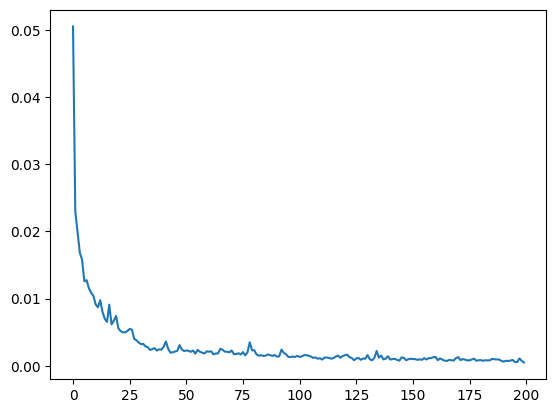

In [40]:
plt.plot(range(len(model.history.history['loss'])),model.history.history['loss'])

## </h2><font size="4">
**3.2 Predict the Price**

Note: In this part, I used past 15 days' sentiment score and price to predict the next day. Since the model could automatically predict a score for the next day, so I used the sentiment score obtained in the real-world to replace the predicted score. Since if we want to predict the next day's stock price, we have already know the sentiment score of previous days, so it would be more accurate to do so.

In [41]:
# Reference: Udemy course: Python for Time Series Data Analysis,https://www.udemy.com/course/python-for-time-series-data-analysis/learn/lecture/14522130#overview
# Guided by chatgpt
# Create a list to store predicted data
test_predictions = []
# Get the last input_n points from the training data
first_eval_batch = scaled[-input_n:]
# reshape the data format
current_batch = first_eval_batch.reshape((1, input_n, n_features))

In [42]:
len(scaled_test)

65

In [43]:
# prediction loop
for i in range(len(scaled_test)):

    # predict
    current_pred = model.predict(current_batch)[0]

    # store results of prediction
    test_predictions.append(current_pred[0])  # assume only care about price

    # get new score
    new_sentiment_score = scaled_test[i, 0]

    # combine the score and predicted price together, and ensure the right dimension
    new_input = np.array([[new_sentiment_score, current_pred[0]]]).reshape((1, 1, n_features))

    # update batch for next prediction
    current_batch = np.append(current_batch[:, 1:, :], new_input, axis=1)

1/1 [==============================] - 0s 29ms/step


In [44]:
#see the length of predictions
len(test_predictions)

65

In [45]:
# Make sure both the price predictions and scores are 2-dimension and combine them into one array for rescaling
test_predictions_array = np.array(test_predictions).reshape(-1, 1)
sentiment_scores = scaled_test[:, 0].reshape(-1, 1)
combined_predictions = np.hstack((sentiment_scores, test_predictions_array))
# rescale
unscaled_predictions = scaler.inverse_transform(combined_predictions)
unscaled_stock_prices = unscaled_predictions[:, 1]
unscaled_stock_prices

array([48.54977352, 42.22943186, 41.06976702, 40.57784303, 39.77239064,
       39.24162808, 38.89796928, 38.51488628, 37.46229324, 37.07627472,
       37.31796752, 37.7339885 , 38.56318104, 40.31929492, 40.45548088,
       40.25461975, 40.50335242, 41.27994656, 42.68918805, 43.11046001,
       42.69320872, 42.02356335, 41.64475446, 41.8345969 , 41.01400179,
       40.25314583, 40.04086   , 40.16099775, 40.28062614, 40.12597069,
       39.44165259, 39.71087492, 40.78153389, 41.33950362, 41.82143746,
       41.29847755, 41.00223507, 41.37913943, 42.6415675 , 43.03350384,
       42.4461542 , 41.68835435, 42.02342802, 42.33417345, 42.12191222,
       42.33664884, 42.3813314 , 41.9581057 , 41.7529926 , 41.36121128,
       41.50327077, 41.89091085, 43.13577742, 42.65490657, 41.99453039,
       41.77681641, 42.20927193, 42.35061783, 42.7134843 , 43.56616601,
       43.21560514, 42.57053407, 41.97800481, 41.49648681, 41.87313035])

## </h2><font size="4">
**3.3 Evaluate the Model and Visualize the predictions**

In [46]:
#make two columns at the same length
test_add_compound = test_df
test_add_compound['Predictions_add_compound'] = unscaled_stock_prices

C:\Users\10788\AppData\Local\Temp\ipykernel_4252\936177275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_add_compound['Predictions_add_compound'] = unscaled_stock_prices


In [47]:
#Evaluate the model using MAE, MSE, MRE
MAE = metrics.mean_absolute_error(test_add_compound['stock'],test_add_compound['Predictions_add_compound'])
MSE = metrics.mean_squared_error(test_add_compound['stock'],test_add_compound['Predictions_add_compound'])
MRE = np.sqrt(MSE)
MAE,MSE,MRE

(9.259078026379408, 157.11235564630036, 12.534446762673667)

In [48]:
test_add_compound.describe()

,stock,Predictions,Predictions_add_compound
count,65.000000,65.000000,65.000000
mean,49.161961,40.931311,41.284234
std,9.170583,2.852232,1.768595
min,36.700001,35.635252,37.076275
25%,41.215000,38.844463,40.280626
50%,47.807499,40.364930,41.644754
75%,53.535000,43.352251,42.334173
max,75.639999,48.594390,48.549774


<Figure size 1500x700 with 0 Axes>

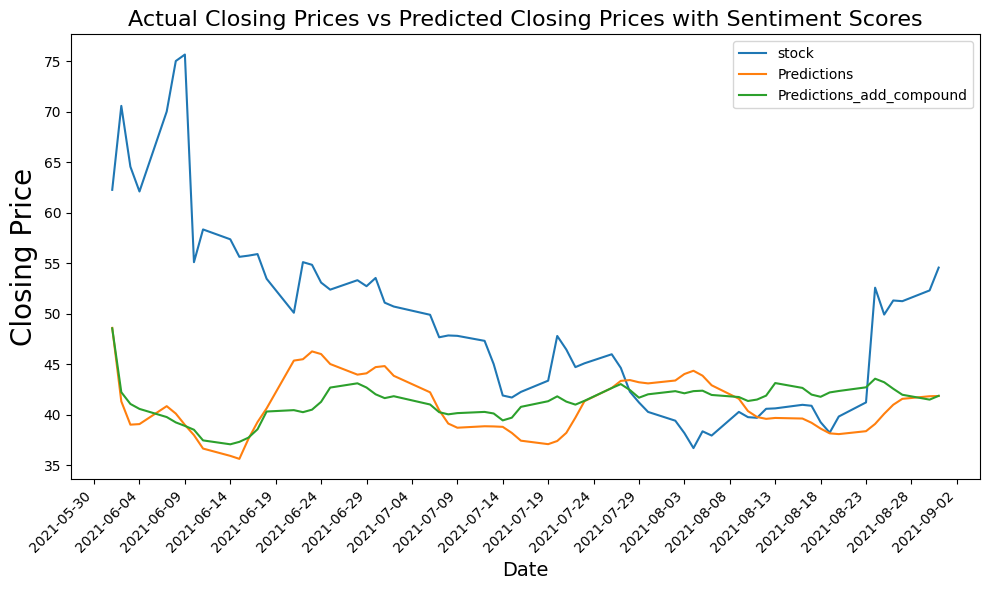

In [49]:
# Plot the time-series data
# Setting the plot size for better readability
plt.figure(figsize=(15, 7))

# Plotting 
test_add_compound.plot(figsize=(10,6))

# Adding title and labels with font size adjustments
plt.title('Actual Closing Prices vs Predicted Closing Prices with Sentiment Scores', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=20)

#Set the date format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 

#Set the x-axis interval to be one month
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5)) 

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish the actual values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

## </h2><font size="4">
**3.4 Conclusion**

1. Real-world stock price higher than the predictions: Everyday excludes 8-19. Real-world stock price lower than the predictions: 8-19
2. The data in the first 20 days of June has a significant difference and even converse between real data and predictions. That indicates that my model does not fit the actual data, and the variance is high. The first reason might be due to the model itself lack of accuracy, another reason might be because there are other factors beyond historical data and sentiment score that I did not capture.
3. The data from 6-24 to 7-24 seems to predict the trend better than the predictions without sentiment score. That gives the proof that adding sentiment score really influences the stock price.
4. See MRE, it is around 14.45, and for this case, the real-world data's sd is 9.17, and the prediction is 3.4, greater than both sd, so it means that my model does not predict the actual data well and the variance is large. Since the stock market is very changeable and many factors influence it, it is hard to predict the data very accurately.

# </h1><font size="6">
**Section 4. Short Squeeze and Model Adaptation**

## </h2><font size="4">
**4.1 Event Analysis**

Objective: In this part, I did volume estimate, topic modeling Using embedding and VADER score to do sentiment analysis.

### </h3><font size="3">
**4.1.1 Load Data**

In this section, I have 3 datasets: Harvard case of whole reddit comments in 2021, reddit API in WallStreetBets about GameStop, Webscraped CNBC news headline related to gamestop.

In [50]:
#Read the file
rGME = pd.read_csv('rGME_dataset_features.csv')

C:\Users\10788\AppData\Local\Temp\ipykernel_4252\3528037558.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  rGME = pd.read_csv('rGME_dataset_features.csv')


Load the first dataset from Harvard case of whole reddit comments in 2021

In [51]:
# Get columns we need
rgme = rGME[['date','title']]
#change time format
rgme['date'] = pd.to_datetime(rgme['date'])
# Get rows in the range of January_May and June_August
rgme1_2 = rgme[(rgme['date'].dt.month >= 1) & (rgme['date'].dt.month <= 2)]
#change the time format
rgme1_2['date'] = rgme1_2['date'].dt.date
#reset index 
rgme1_2.set_index('date', inplace=True)

C:\Users\10788\AppData\Local\Temp\ipykernel_4252\1811388808.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rgme['date'] = pd.to_datetime(rgme['date'])
C:\Users\10788\AppData\Local\Temp\ipykernel_4252\1811388808.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rgme1_2['date'] = rgme1_2['date'].dt.date


Load reddit API in WallStreetBets about GameStop

In [52]:
WallStreetBets = pd.read_csv('gamestop_WallStreetBets.csv')
#change time format
WallStreetBets['time'] = pd.to_datetime(WallStreetBets['time'])
# Get rows in the range of January_May and June_August
WallStreetBets = WallStreetBets[(WallStreetBets['time'].dt.month >= 1) & (WallStreetBets['time'].dt.month <= 2)]
#change the time format
WallStreetBets['date'] = WallStreetBets['time'].dt.date
#drop unneeded column, reset index and column name
WallStreetBets = WallStreetBets.drop('time',axis=1)
WallStreetBets.set_index('date', inplace=True)
WallStreetBets.columns = ['title']

Load CNBC news data

In [53]:
cnbc = pd.read_csv('gamestop_cnbc.csv')
#change time format
cnbc['time'] = pd.to_datetime(cnbc['time'])
# Get rows in the range of January_May and June_August
cnbc = cnbc[(cnbc['time'].dt.month >= 1) & (cnbc['time'].dt.month <= 2)]
#change the time format
cnbc['date'] = cnbc['time'].dt.date
#drop unneeded column, reset index and column name
cnbc = cnbc.drop('time',axis=1)
cnbc.set_index('date', inplace=True)
cnbc.columns = ['title']

Check three datasets

In [54]:
rgme1_2.head()

,title
date,
2021-01-04,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀
2021-01-04,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀
2021-01-05,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...
2021-01-05,You already know what we must do brothers and ...
2021-01-06,ICR conference (11th Jan)


In [55]:
WallStreetBets.head()

,title
date,
2021-01-28,What's the next Gamestop?
2021-01-29,"GameStop Update 3: Can't Stop, Won't Stop, Gam..."
2021-01-30,BREAKING: SEC issues ruling on GameStop stock ...
2021-01-30,GameStop covered in Taiwan news featuring DFV 🚀🚀🚀
2021-01-29,Soon we'll all be able to buy our own GameStop...


In [56]:
cnbc.head()

,title
date,
2021-02-18,Interactive Brokers chair says financial syste...
2021-01-29,This is how Wall Street thinks the Reddit-fuel...
2021-01-28,Beware these ETFs containing a GameStop bubble...
2021-01-29,Op-ed: Gamestop's costly financial lesson for ...
2021-02-17,'Roaring Kitty' Keith Gill defends GameStop po...


combine 3 dataframes into one dataframe

In [57]:
# combine 3 dataframes into one dataframe
reviews = pd.concat([rgme1_2, WallStreetBets, cnbc], axis=0)
# set another copy of reviews for modeling
reviews_topic = reviews

### </h3><font size="3">
**4.1.2 Volume Estimate**

In [58]:
# Group the data by date
count_reviews = reviews.groupby(reviews.index).count()

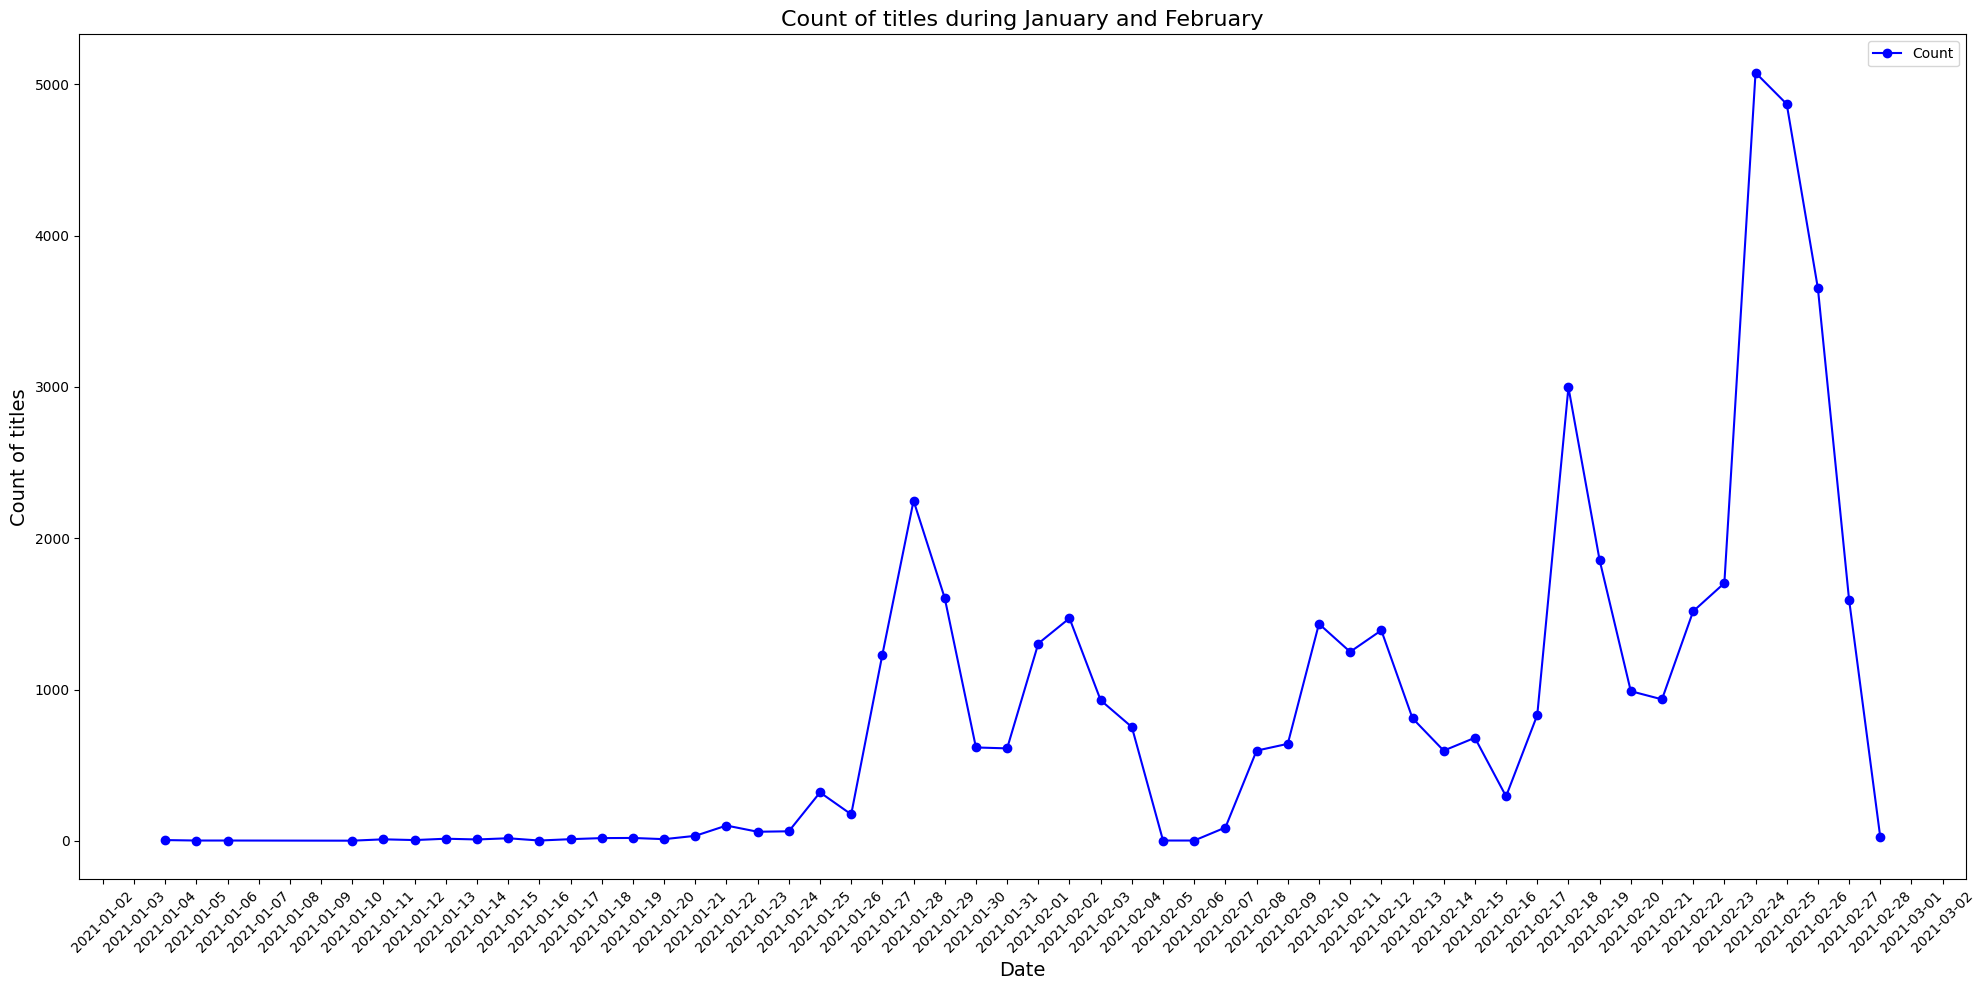

In [59]:
#Visualize the amount of daily reviews
# Setting the plot size for better readability
fig, ax = plt.subplots(figsize = (20,10))

# Plotting the actual closing prices in the training period
ax.plot(count_reviews.title, label='Count', color='blue', marker='o')

# Adding title and labels with font size adjustments
plt.title('Count of titles during January and February', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Count of titles', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

#Set the date format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 

#Set the x-axis interval to be one month
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1)) 
# Adding a legend to distinguish the actual values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

Conclusion:  
1. It seems that the amount of reviews about GameStop has been gradually increasing since late January, and there is an overall increase trend of review volume along with five seasonalities.
2. The volume at around 2-20 is at the peak, with over 5k reviews on the GameStop, it might due to the spread of the success of the company and the increase amount of press on GameStop.


### </h3><font size="3">
**4.1.3  Topic modeling: Key Themes Estimate**

In this part, I use embedding and let the model unsupervised create 8 topics for me with  10 top occurrence words each.

In [60]:
#linguistic processing
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

def text_process(mess):
    #create a stemmer object
    stemmer = PorterStemmer()
    #remove puc
    nopunc = [char for char in mess if char not in string.punctuation]
    #remove stop words and stemming
    nopunc=''.join(nopunc)
    return ' '.join(stemmer.stem(word) for word in nopunc.split() if word.lower() not in stopwords.words('english'))

In [61]:
reviews_processed = reviews['title'].apply(text_process)

In [62]:
# change to dataframe
reviews_processed = pd.DataFrame(reviews_processed, columns=['title'])

In [63]:
reviews_processed

,title
date,
2021-01-04,need see gme 🚀🚀🚀🚀🚀🚀
2021-01-04,short squeez incom 🚀🚀🚀🚀🚀🚀🚀
2021-01-05,convinc 💰gme extrem pump come
2021-01-05,alreadi know must brother sister submit compla...
2021-01-06,icr confer 11th jan
...,...
2021-02-02,stay cours stock market even amid gamestop tra...
2021-02-04,fed mester doesnt see polici chang come gamest...
2021-02-05,robinhood lift trade restrict gamestop stock


In [64]:
reviews_processed = reviews_processed.reset_index()

In [65]:
# Code reference: Udemy course NLP - Natural Language Processing with Python
# https://www.udemy.com/course/nlp-natural-language-processing-with-python/learn/lecture/13067612#overview
# Create a vectorizer, set indicators
cv = CountVectorizer(max_df = 0.7, min_df = 10, stop_words = 'english')
# Train the cv
matrix = cv.fit_transform(reviews_processed['title'])
LDA = LatentDirichletAllocation(n_components = 8,random_state=101)
LDA.fit(matrix)
#Get the words vocabulary
cv.get_feature_names_out()

array(['01', '10', '100', ..., 'youv', 'zero', 'zoom'], dtype=object)

In [66]:
# Get the topic array
LDA.components_

array([[1.25040346e-01, 1.25107201e-01, 1.11882231e+01, ...,
        1.25154268e-01, 4.45222851e+01, 1.25013638e-01],
       [1.25038466e-01, 1.75436460e-01, 1.34244701e+00, ...,
        1.25082264e-01, 1.64462003e-01, 9.06814670e+00],
       [1.20556113e+01, 1.95560158e+02, 3.77776807e+02, ...,
        1.08213284e+00, 2.47196540e+00, 1.25007008e-01],
       ...,
       [1.25038276e-01, 1.25067549e-01, 1.25106156e-01, ...,
        6.83030028e+00, 1.01572142e+01, 1.71813895e+01],
       [1.25153226e-01, 1.77637496e+00, 3.89530514e+00, ...,
        1.25027771e-01, 1.25181419e-01, 1.25026975e-01],
       [1.93997207e-01, 2.39528832e+00, 2.39265188e+01, ...,
        5.89358378e+00, 1.27315364e-01, 1.25147303e-01]])

In [67]:
# Loop topic to print words for each topic
for i, topic in enumerate(LDA.components_):
    print(f"Top10 words for topic #{i}")
    print([cv.get_feature_names_out() [index] for index in topic.argsort()[-10:]])
    print('\n')

Top10 words for topic #0
['fuck', 'new', 'wait', 'love', 'gamestop', 'happen', 'robinhood', 'fund', 'hedg', 'stop']


Top10 words for topic #1
['support', 'togeth', 'ape', 'way', 'strong', 'buy', 'line', 'gamestop', 'gme', 'hold']


Top10 words for topic #2
['price', 'today', 'amc', 'bought', 'fuck', 'dip', 'share', 'sell', 'buy', 'gme']


Top10 words for topic #3
['moon', 'time', 'know', 'right', 'look', 'let', 'volum', 'gme', 'today', 'hear']


Top10 words for topic #4
['trade', 'feel', 'open', 'question', 'dfv', 'dont', 'gme', 'market', 'stock', 'like']


Top10 words for topic #5
['pleas', 'game', 'thank', 'fellow', 'els', 'anyon', 'melvin', 'help', 'retard', 'ape']


Top10 words for topic #6
['posit', 'order', 'cover', 'option', 'gamestop', 'post', 'wsb', 'gme', 'squeez', 'short']


Top10 words for topic #7
['meme', 'im', 'good', 'need', 'hodl', 'dd', 'day', 'diamond', 'hand', 'gme']




Conclusion:  
After carefully viewing 8 topics and their top 10 words, I summarized the useful information as follows:  
1. Positive review and expectations: Topic including #0(new, wait, love, happen), #1(support, strong, buy), #3(right), #4(open, like), #7(good, need, diamond)
2. Stock market concern: Topic including #0(hedge, fund), #2(price, sell, buy), #4(trade, market, stock)
3. So overall, apart from common words people use on social media, it showed us a positive vision about Gamestop especially its market performance and stock.

### </h3><font size="3">
**4.1.4  VADER: Sentiment analysis**

In [68]:
# Load the SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\10788\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [69]:
# Set the list to store data and load model
sid = SentimentIntensityAnalyzer()
scores = []

In [70]:
# Analyze in loop
for title in reviews['title']:
    score = sid.polarity_scores(title)
    scores.append(score)

In [71]:
# change to dataframe and check te value
scores = pd.DataFrame(scores)
reviews['compound'] = scores['compound'].values
reviews.head()

,title,compound
date,,
2021-01-04,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,0.0000
2021-01-04,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,0.0000
2021-01-05,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,0.4019
2021-01-05,You already know what we must do brothers and ...,-0.2960
2021-01-06,ICR conference (11th Jan),0.0000


In [72]:
# Group the compound by day
reviews = reviews.groupby('date').mean('compound')

Visualize the daily sentiment score

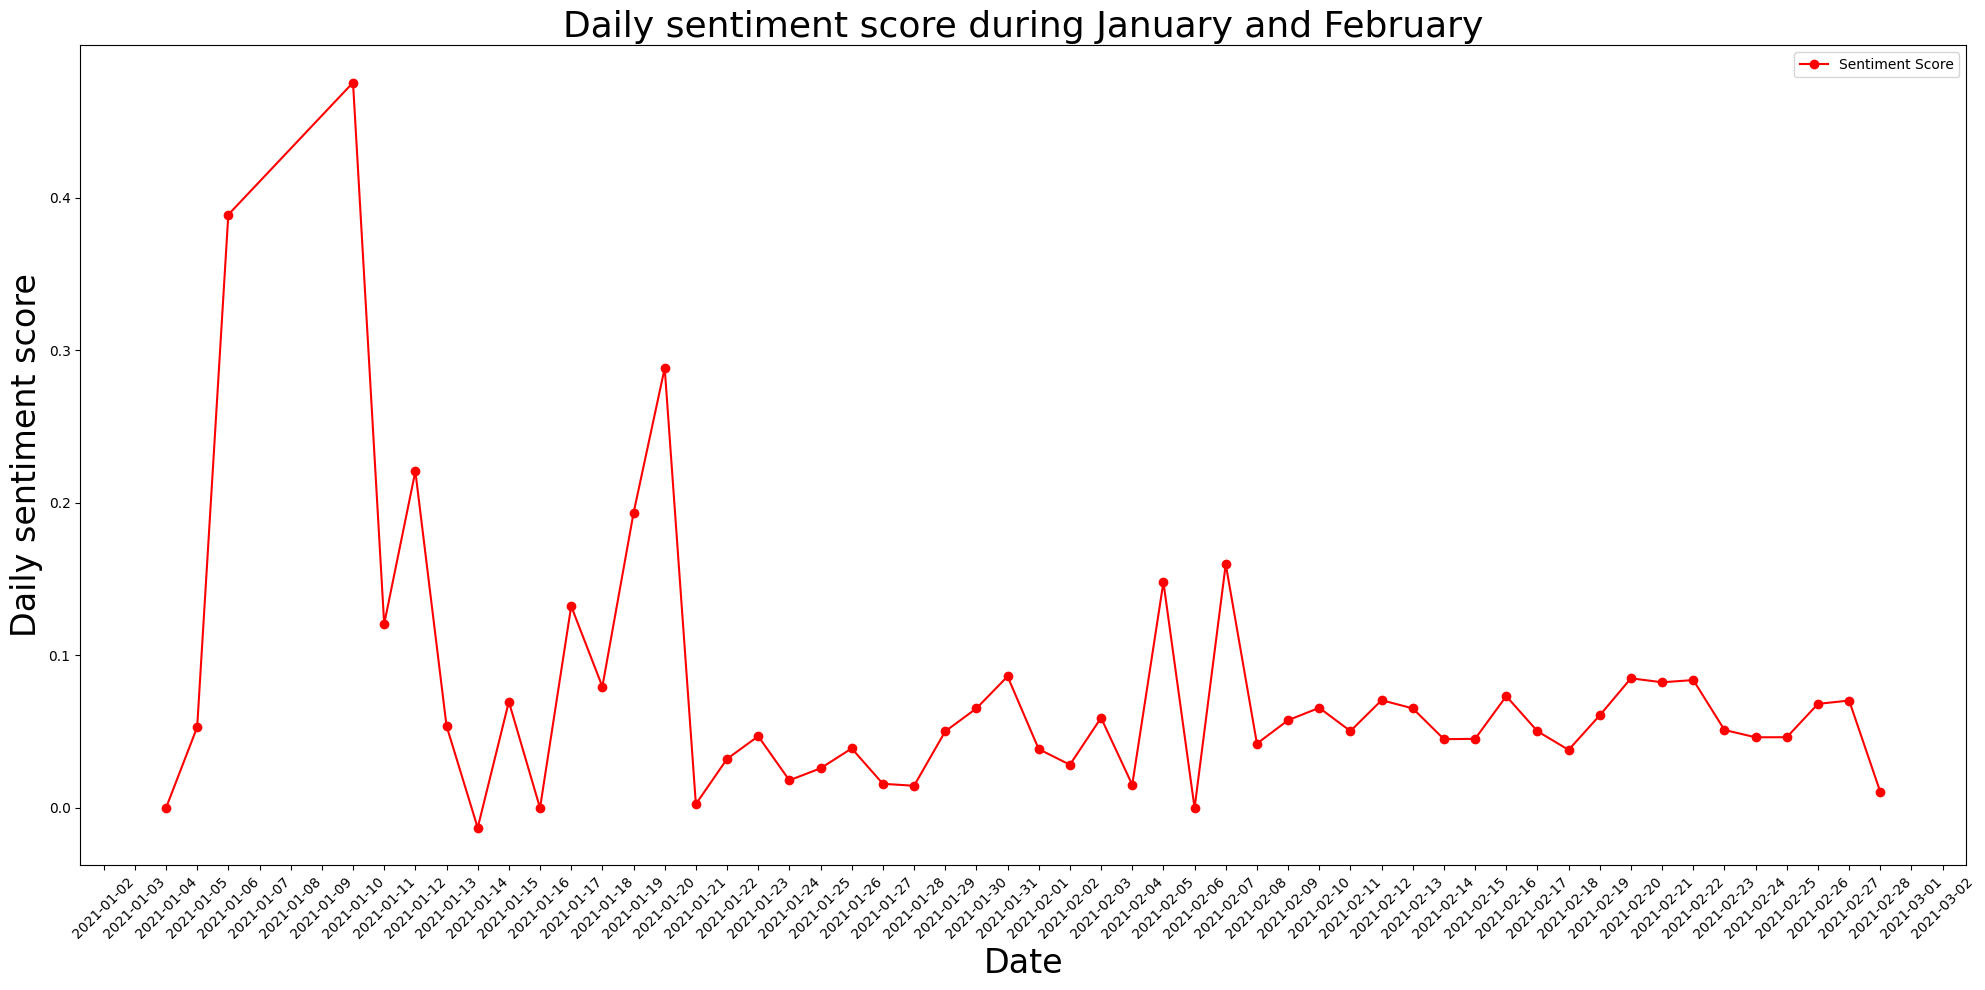

In [73]:
# Setting the plot size for better readability
fig, ax1 = plt.subplots(figsize = (20,10))

# Plotting the actual closing prices in the training period
ax1.plot(reviews['compound'], label='Sentiment Score', color='red', marker='o')
# Adding title and labels with font size adjustments
plt.title('Daily sentiment score during January and February', fontsize=26)
plt.xlabel('Date', fontsize=24)
plt.ylabel('Daily sentiment score', fontsize=24)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

#Set the date format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 

#Set the x-axis interval to be one month
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1)) 
# Adding a legend to distinguish the actual values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

Conclusion:  
1. Almost every day's sentiment score is higher than 0, meaning the daily score is positive during January and February.
2. It shows that at the start of January, the mean sentiment score was higher than the days later. And during the start of February, there are some high score days.
3. These positive sentiment scores might influence people's positive expectations of GameStop's stock price in the future.

## </h2><font size="4">
**4.2 Model Sensitivity**

##
Section 4 Sensitivity test

In this section, to test how my model would change based on the sudden great change of sentiment scores. Since I detected most dates in January and February , the sentiment score is positive, so I would love to simulate some extreme negative sentiment scores for June, July and August. Then I will use the same model as section 3 to see how predicted stock price would change and deviate from the actual stock price.

In [74]:
len(values_test)

65

In [75]:
#simulate extreme negative sentiment scores for the period needed to be predicted.
np.random.seed(101)
score_simulated = np.random_numbers = np.random.uniform(-0.9, -0.6, 65)
#score_simulated = pd.DataFrame(score_simulated, columns=['Random Numbers'])

In [76]:
score_simulated

array([-0.74508041, -0.72879972, -0.89145773, -0.8485435 , -0.69441691,
       -0.64983094, -0.80791013, -0.63191608, -0.68353684, -0.84301831,
       -0.73373172, -0.79436041, -0.84543228, -0.66431947, -0.61035503,
       -0.8302939 , -0.87493157, -0.71893547, -0.68130217, -0.81712835,
       -0.6944081 , -0.74463976, -0.88545464, -0.85863923, -0.84390977,
       -0.60170463, -0.74380038, -0.72636314, -0.67955428, -0.73741147,
       -0.62605393, -0.65762395, -0.77910065, -0.7928327 , -0.61413699,
       -0.79691053, -0.64047006, -0.65091669, -0.73855157, -0.62325919,
       -0.87085606, -0.86914575, -0.68954781, -0.63285604, -0.85213191,
       -0.81732824, -0.69825254, -0.85070906, -0.68958866, -0.75370943,
       -0.69579667, -0.74353554, -0.88698099, -0.83281902, -0.72743847,
       -0.8638699 , -0.74996499, -0.85859713, -0.88415748, -0.84651692,
       -0.76728956, -0.6367238 , -0.61522076, -0.75654977, -0.7616642 ])

##
4.2 predict the data using simulated score

In [77]:
# Reference: Udemy course: Python for Time Series Data Analysis,https://www.udemy.com/course/python-for-time-series-data-analysis/learn/lecture/14522130#overview
# Guided by chatgpt
# Create a list to store predicted data
simulated_predictions = []
# Get the last input_n points from the training data
first_eval_batch = scaled[-input_n:]
# reshape the data format
current_batch = first_eval_batch.reshape((1, input_n, n_features))

In [78]:
# prediction loop
for i in range(len(values_test)):

    # predict
    current_pred = model.predict(current_batch)[0]

    # store results of prediction
    simulated_predictions.append(current_pred[0])  # assume only care about price

    # get new score
    new_sentiment_score = score_simulated[i]

    # combine the score and predicted price together, and ensure the right dimension
    new_input = np.array([[new_sentiment_score, current_pred[0]]]).reshape((1, 1, n_features))

    # update batch for next prediction
    current_batch = np.append(current_batch[:, 1:, :], new_input, axis=1)

1/1 [==============================] - 0s 27ms/step


In [79]:
len(simulated_predictions)

65

In [80]:
# Make sure both the price predictions and scores are 2-dimension and combine them into one array for rescaling
simulated_predictions_array = np.array(simulated_predictions).reshape(-1, 1)
sentiment_scores = scaled_test[:, 0].reshape(-1, 1)
combined_predictions = np.hstack((sentiment_scores, simulated_predictions_array))
# rescale
unscaled_predictions = scaler.inverse_transform(combined_predictions)
unscaled_stock_prices = unscaled_predictions[:, 1]
unscaled_stock_prices

array([ 48.54977352,  61.56690845,  95.86094331, 137.34618066,
       147.66770163,  91.69047273,  43.65637512,  48.11743612,
        49.32493558,  56.32825429,  69.52576316,  75.26234031,
        78.22508013,  71.50496995,  56.94330323,  45.62017345,
        36.22966338,  26.17615902,  15.05683821,  15.32992617,
        24.03530245,  33.44841955,  44.11937196,  56.67507993,
        68.04544886,  73.49272496,  67.11933707,  50.4436211 ,
        45.30916966,  51.61131743,  62.91506729,  72.67176076,
        82.12101343,  90.69435113,  88.55116311,  70.89134817,
        55.84381061,  48.49838083,  47.45210669,  51.95809877,
        56.3677277 ,  60.3741137 ,  69.57830742,  71.08458136,
        59.22733764,  49.76622475,  46.45921835,  42.35644214,
        42.4740971 ,  47.12696412,  51.87549546,  59.25909452,
        66.72824964,  72.05887718,  73.78368448,  66.41805293,
        54.96884545,  48.62506384,  50.61232673,  61.86171146,
        71.688774  ,  77.74316105,  74.28640079,  59.59

##
4.3 Visualize the findings

In [81]:
#make two columns at the same length
extreme_negative_price = test_df[['stock']]
extreme_negative_price['Predictions_extreme_negative_score'] = unscaled_stock_prices
# make the simulated score scaled to be larger to detect
extreme_negative_price['Sentiment Score(*100)'] = score_simulated*100

C:\Users\10788\AppData\Local\Temp\ipykernel_4252\2949804420.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extreme_negative_price['Predictions_extreme_negative_score'] = unscaled_stock_prices


In [82]:
extreme_negative_price

,stock,Predictions_extreme_negative_score,Sentiment Score(*100)
Date,,,
2021-06-01,62.255001,48.549774,-74.508041
2021-06-02,70.559998,61.566908,-72.879972
2021-06-03,64.544998,95.860943,-89.145773
2021-06-04,62.090000,137.346181,-84.854350
2021-06-07,70.002502,147.667702,-69.441691
...,...,...,...
2021-08-25,49.912498,71.688774,-76.728956
2021-08-26,51.305000,77.743161,-63.672380
2021-08-27,51.237499,74.286401,-61.522076


<Figure size 1500x700 with 0 Axes>

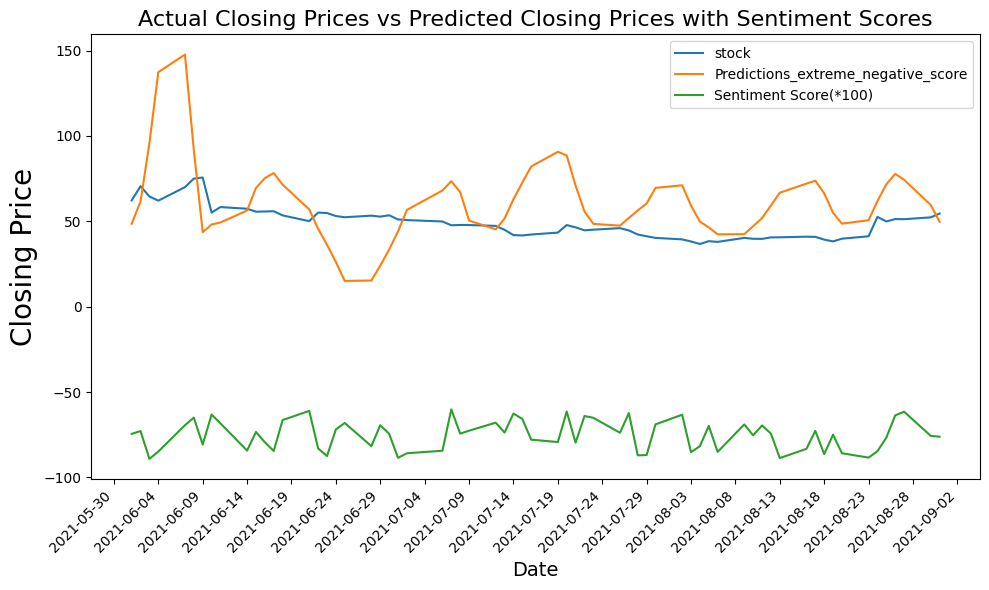

In [83]:
# Plot the time-series data
# Setting the plot size for better readability
plt.figure(figsize=(15, 7))

# Plotting 
extreme_negative_price.plot(figsize=(10,6))

# Adding title and labels with font size adjustments
plt.title('Actual Closing Prices vs Predicted Closing Prices with Sentiment Scores', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=20)

#Set the date format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 

#Set the x-axis interval to be one month
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5)) 

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish the actual values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

Conclusion:  
1. When I simulated the extreme negative scores for June to August, it seemed that there would be more fluctuations than the actual price. The highest and the lowest price would be very extreme.
2. Why extreme might occur: there are many reasons and uncertainties since it is a stock market. The reputation of the company, opinion leaders comments on the company's operation, spread of some products' negative reviews, anecdotes of high executives of the company, etc. Even a small event could cause extreme negative sentiment on the company's stock price and attraction. Accumulated negative reviews on social media and in the industries could quickly spread and then influence the expectations on the company's stock market which might cause the decrease or fluctuation of the stock price.
3. Algorithmic analysis: Although the sentiment score is extremely negative for every day, the predicted price is sometimes higher than the actual. That might be due to the good performance of previous historical data. Because I use both the historical data and sentiment score to train the model and make predictions. Even if the sentiment score might decrease the price, the historical data if good will drag the price up as well.
4. Adjustment suggestions: If I want my model's predictions to perform better, I might do as follows：(a) adding features that also influence the price, such as the cash flow of big shareholders' decisions, microeconomic index(unemployment rate, inflation rate, etc), GameStop's promotion activities, competitors, etc. It depends on the situation. (b)Stack two different models rather than train two features in the same model. (c)Manually set some weights to punish outliers or larger the price since we know the trend of the future but the model does not. (d) Do better feature engineering such as using more related and crucial datasets rather than the whole dataset.
 

# </h1><font size="6">
**Section 5. Conclusion and Future Directions**

## </h2><font size="4">
**Please see details in the word document in the file.**

# </h1><font size="6">
**Thank You For Watching!**

## </h2><font size="4">
If you have any questions or suggestions on my work, feel free to contact me at jingyuch@andrew.cmu.edu! I am more than happy to discuss with you!